# Projekat 3 - duboko učenje

**Dataset**: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors

**Definicija problema**: Klasifikacija slika za papir-kamen-makaze

**Vrsta problema**: višeklasna klasifikacija

## Učitavanje *dataset*-a

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import cv2
import os
import random
import tensorflow as tf

In [2]:
main_directory = 'dataset/'
subfolders = ['paper','rock','scissors']

dataset=[]
label=0
for subfolder in subfolders:
    folder = os.path.join(main_directory,subfolder)
    for image in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,image),cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (75, 50))
        #img = img.flatten()
        img = img/255.0
        dataset.append((img,label))
    label+=1
random.shuffle(dataset)
X, y =zip(*dataset)

X = np.array(X)
y = np.array(y)

*Dataset* se sastoji od slika položaja šake za papir, kamen i makaze. 

Slike se učitavaju u *grayscale* formatu (budući da informacija o bojama nije potrebna za rešavanje datog problema), i zatim se skaliraju na manje dimenzije. Ovakva reprezentacija se pretapa u *numpy* niz, a vrednosti svakog elementa skaliraju u odnosu na 255, što je maksimalna vrednost jednog piksela slike. 

Kroz samo učitavanje slika, enkodiraju se i kategoričke labele u sledećem formatu:
- 0 - *paper*
- 1 - *rock*
- 2 - *scissors*

Na ovaj način se kreiraju *feature* vektor i *target* vektor. *Shuffle* funkcija se koristi da izmeša uzorke tako da u kasnijem treniranju mreže ne dođe do *bias*-a usled sukcesivnih podataka koji pripadaju istoj klasi.

In [3]:
print(X.shape)

(2188, 50, 75)


Oblik *feature* vektora govori da se u *dataset*-u nalazi 2188 uzoraka, i da je svaka slika enkodirana kao vektor od 3750 float vrednosti.

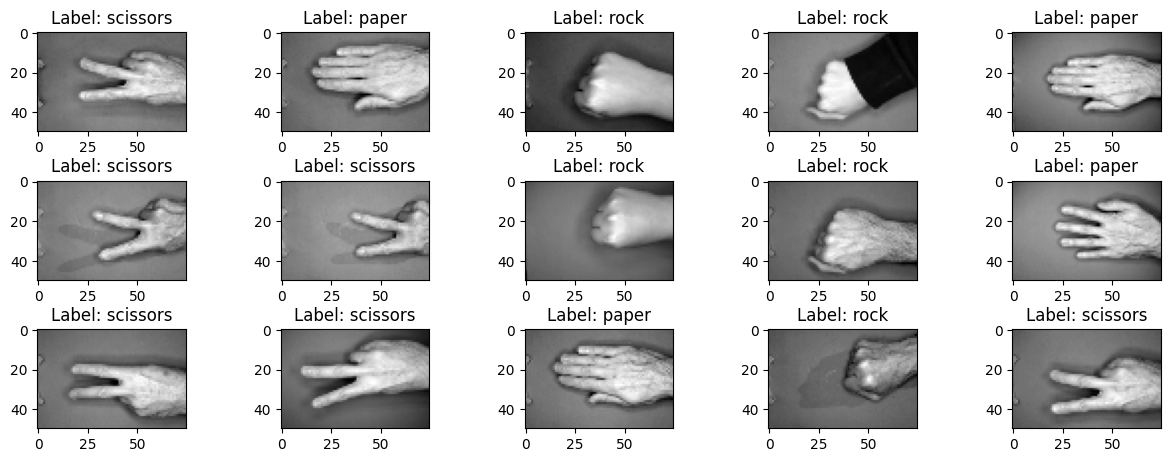

In [4]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(15):
    n+=1
    plt.subplot(5, 5, n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.3)
    plt.imshow(X[i], cmap='gray')
    plt.title(f'Label: {subfolders[y[i]]}')

Grafik iznad prikazuje izgled učitanih i skaliranih slika.

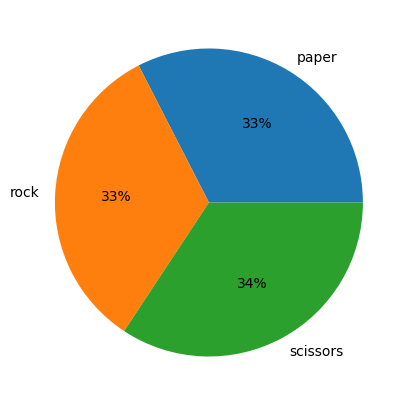

In [5]:
plt.figure(figsize=(7, 5))
unique, counts = np.unique(y,return_counts=True)

pie = plt.pie(counts,labels = subfolders, autopct='%1.0f%%')
plt.show()

Grafik iznad prikazuje distribuciju podataka po klasama. Uočava se da je u pitanju gotovo idealna podela, gde svaka klasa ima jednak broj uzoraka.

TODO: 
- Pitati profesora za ImageDataGenerator
- Pitati za loss funkciju sta misli

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2)

In [7]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [8]:
network = Sequential()
network.add(Conv2D(filters=64, kernel_size=(5,5),input_shape=(50,75,1),activation='relu'))
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.5))
network.add(Flatten())
network.add(Dense(128,activation='relu'))
network.add(Dropout(0.5))
network.add(Dense(3,activation='softmax'))

In [9]:
network.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [10]:
network.fit(X_train,y_train,epochs=25,verbose=2,batch_size=64,validation_data=(X_test,y_test))

Epoch 1/25
28/28 - 3s - loss: 1.4695 - accuracy: 0.4029 - val_loss: 1.2376 - val_accuracy: 0.3311 - 3s/epoch - 99ms/step
Epoch 2/25
28/28 - 0s - loss: 0.9453 - accuracy: 0.5863 - val_loss: 0.9957 - val_accuracy: 0.4406 - 473ms/epoch - 17ms/step
Epoch 3/25
28/28 - 0s - loss: 0.6861 - accuracy: 0.7400 - val_loss: 0.4856 - val_accuracy: 0.8584 - 476ms/epoch - 17ms/step
Epoch 4/25
28/28 - 0s - loss: 0.4843 - accuracy: 0.8269 - val_loss: 0.4202 - val_accuracy: 0.8630 - 476ms/epoch - 17ms/step
Epoch 5/25
28/28 - 0s - loss: 0.3972 - accuracy: 0.8629 - val_loss: 0.3634 - val_accuracy: 0.8516 - 468ms/epoch - 17ms/step
Epoch 6/25
28/28 - 0s - loss: 0.3021 - accuracy: 0.9011 - val_loss: 0.2688 - val_accuracy: 0.9247 - 470ms/epoch - 17ms/step
Epoch 7/25
28/28 - 0s - loss: 0.2854 - accuracy: 0.9074 - val_loss: 0.2105 - val_accuracy: 0.9361 - 464ms/epoch - 17ms/step
Epoch 8/25
28/28 - 0s - loss: 0.2220 - accuracy: 0.9246 - val_loss: 0.3378 - val_accuracy: 0.8653 - 467ms/epoch - 17ms/step
Epoch 9/25
